In [1]:
import os
import re
import random
import pandas as pd
import numpy as np
from collections import Counter
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Function to read install.log
def read_install_log(filepath):
    try:
        with open(filepath, 'r') as file:
            return file.readlines()
    except FileNotFoundError:
        return None

In [3]:
def extract_log_info(log_lines):
    if not log_lines:
        return None, None, None, None, None, None

        
    start_time_str = None
    end_time_str = None
    success = False
    stage_name = []
    last_lines = log_lines[-10:]  # Adjust as needed to capture the last relevant lines
    last_lines_content = ''.join(last_lines)
     # Regex pattern
    pattern =  r"STAGE:\s+([^\s]+)"

    # Find all matches in the log
    matches = re.findall(pattern, ''.join(log_lines[0:]))

    # Print stage names and durations
    for match in matches:
        stage_name.append(match)
    stage_names = set(stage_name)
    success = 'Succeeded' in last_lines_content and 'Failed' not in last_lines_content and 'Aborting' not in last_lines_content and 'Error' not in last_lines_content

    
    # Find start time from the first non-empty line
    for line in log_lines:
        if line.strip():
            start_time_str = line.split()[0]
            break
    
    # Find end time from the last line that contains a timestamp
    for line in reversed(log_lines):
        if any(c.isdigit() for c in line.split()[0]):
            end_time_str = line.split()[0]
            break
    
    try:
        start_time = datetime.strptime(start_time_str, "%Y-%m-%dT%H:%M:%S.%fZ")
    except (ValueError, TypeError):
        start_time = None
    
    try:
        end_time = datetime.strptime(end_time_str, "%Y-%m-%dT%H:%M:%S.%fZ")
    except (ValueError, TypeError):
        end_time = None
    
    if start_time is not None and end_time is not None:
        duration = (end_time - start_time).total_seconds()
    else:
        duration = None
    
    return start_time, end_time, duration, stage_names, success


In [4]:
# Function to get folder size
def get_folder_size(folder_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)
    return total_size

In [5]:
# Function to process logs from both directory structures
def process_logs(main_directory):
    data = []
    original_dir = os.path.join(main_directory)
    new_dir = os.path.join(main_directory, 'logs-new')
    
    # Process original directory structure
    for job_folder in os.listdir(original_dir):
        job_path = os.path.join(original_dir, job_folder)
        install_log_path = os.path.join(job_path, 'install.log')
        
        log_lines = read_install_log(install_log_path)
        if log_lines:
            start_time, end_time, duration, stage_name,success = extract_log_info(log_lines)
            folder_size = get_folder_size(job_path)
            data.append({
                'Job Name': job_folder,
                'Start Time': start_time,
                'End Time': end_time,
                'Duration (seconds)': duration,
                'Size (bytes)': folder_size,
                'Stage': stage_name,
                'Success': success,
            })
    
    # Process new directory structure
    for folder in os.listdir(new_dir):
        folder_path = os.path.join(new_dir, folder, 'log')
        for job_folder in os.listdir(folder_path):
            job_path = os.path.join(folder_path, job_folder)
            install_log_path = os.path.join(job_path, 'install.log')
            
            log_lines = read_install_log(install_log_path)
            if log_lines:
                start_time, end_time, duration, stage_name,success = extract_log_info(log_lines)
                folder_size = get_folder_size(job_path)
                data.append({
                    'Job Name': job_folder,
                    'Start Time': start_time,
                    'End Time': end_time,
                    'Size (bytes)': folder_size,
                    'Duration (seconds)': duration,
                    'Stage': stage_name,
                    'Success': success,
                })
    
    df = pd.DataFrame(data)
    return df

In [6]:
main_directory = 'C:/Users/heman/Desktop/HPE/Project Logs HPE'

In [7]:
df = process_logs(main_directory)

In [8]:
print(df)

           Job Name                 Start Time                   End Time  \
0    20240322064543 2024-03-22 06:45:43.951620 2024-03-22 07:02:26.081594   
1    20240322080604 2024-03-22 08:06:04.148283 2024-03-22 08:07:15.658193   
2    20240322085811 2024-03-22 08:58:11.452315 2024-03-22 08:59:22.841931   
3    20240322092456 2024-03-22 09:24:56.214525 2024-03-22 09:25:58.686354   
4    20240322092911 2024-03-22 09:29:11.844639 2024-03-22 09:30:35.207580   
..              ...                        ...                        ...   
442  20240423211242 2024-04-23 21:12:42.704389 2024-04-23 21:14:21.469920   
443  20240423211444 2024-04-23 21:14:44.104676 2024-04-23 21:16:49.523696   
444  20240423214055 2024-04-23 21:40:55.384074 2024-04-23 21:43:13.926914   
445  20240427144917 2024-04-27 14:49:17.520698 2024-04-27 14:49:18.164749   
446  20240427145102 2024-04-27 14:51:02.902686 2024-04-27 14:51:03.341372   

     Duration (seconds)  Size (bytes)                Stage  Success  
0    

Success: 153 PASS and 294 FAIL
       Size (bytes)  Duration (seconds)
count  4.470000e+02          447.000000
mean   1.054098e+06         1039.099619
std    4.950193e+06         3156.061212
min    9.220000e+02            0.005131
25%    2.718100e+04            1.721675
50%    1.698650e+05           95.591032
75%    3.341095e+05          526.111318
max    4.197213e+07        46936.447860


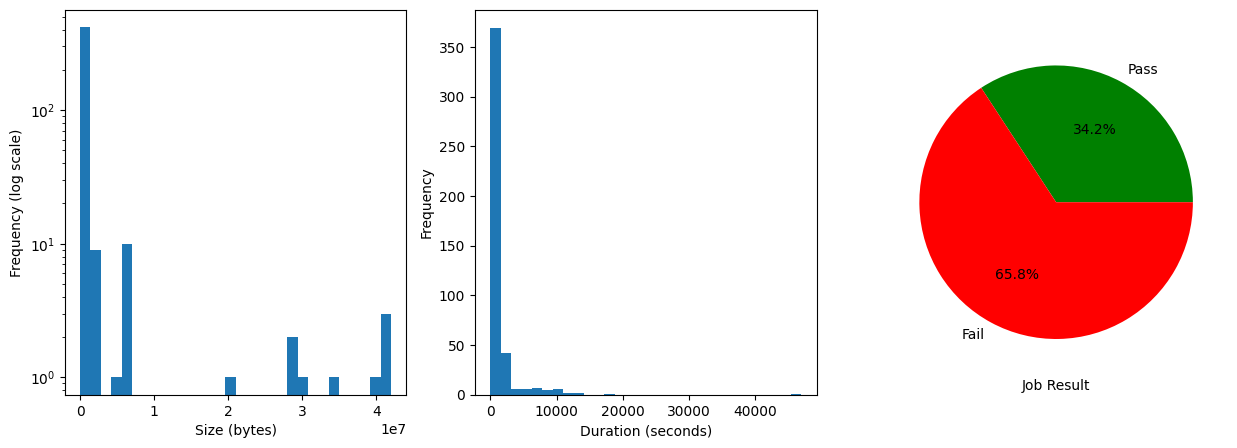

In [9]:
# Overview of the metadata
success_count = df[df['Success']]['Success'].count()
failure_count = (~df['Success']).sum()
print(f"Success: {success_count} PASS and {failure_count} FAIL")

# Describe the DataFrame
description = df[['Size (bytes)', 'Duration (seconds)']].describe()
print(description)

# Graphical overview of distributions
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].hist(df["Size (bytes)"], log=True, bins=30)
axs[0].set_xlabel("Size (bytes)")
axs[0].set_ylabel("Frequency (log scale)")

axs[1].hist(df["Duration (seconds)"], bins=30)
axs[1].set_xlabel("Duration (seconds)")
axs[1].set_ylabel("Frequency")

results = [success_count, failure_count]
axs[2].pie(results, autopct="%1.1f%%", labels=["Pass", "Fail"], colors=["green", "red"])
axs[2].set_xlabel("Job Result")

plt.show()

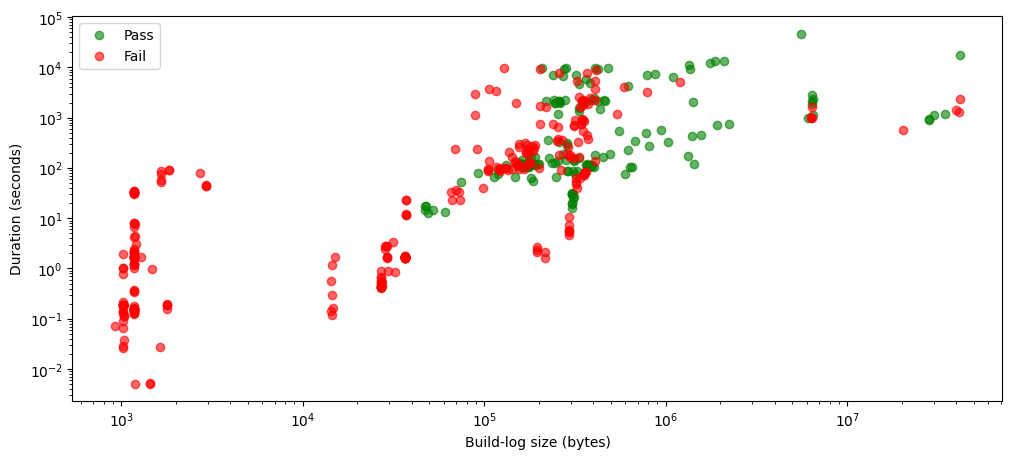

In [10]:
plt.figure(figsize=(12,5))
plt.plot(df[df['Success']]['Size (bytes)'], df[df['Success']]['Duration (seconds)'], "go", alpha=0.6, label="Pass")
plt.plot(df[~df['Success']]['Size (bytes)'], df[~df['Success']]['Duration (seconds)'], "ro", alpha=0.6, label="Fail")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Build-log size (bytes)")
plt.ylabel("Duration (seconds)")
plt.legend()
plt.show()


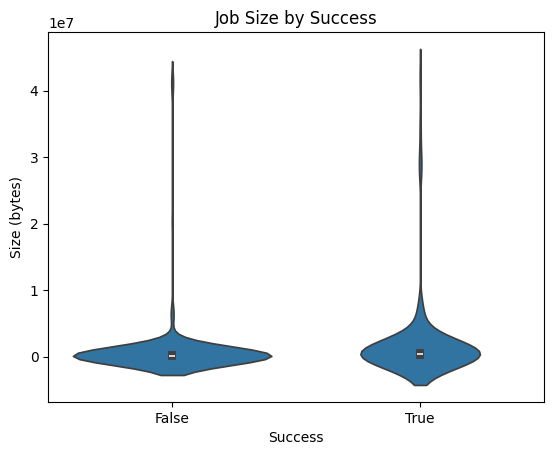

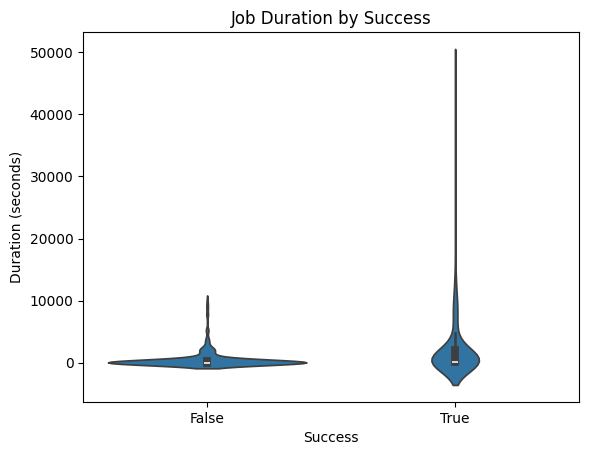

In [11]:
sns.violinplot(x='Success', y='Size (bytes)', data=df)
plt.title("Job Size by Success")
plt.show()

sns.violinplot(x='Success', y='Duration (seconds)', data=df)
plt.title("Job Duration by Success")
plt.show()

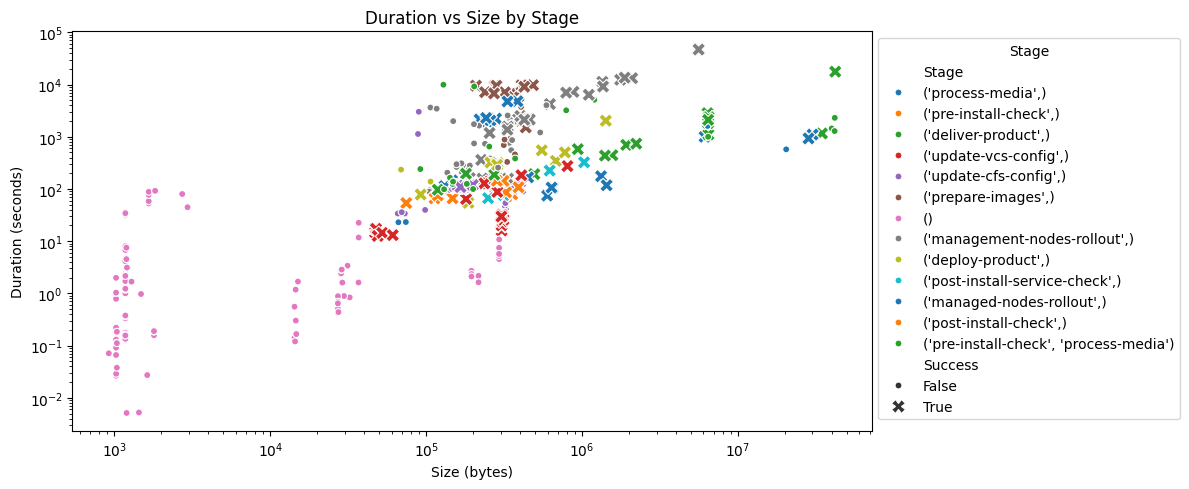

In [12]:
# Plotting with seaborn
df['Stage'] = df['Stage'].apply(tuple)
plt.figure(figsize=(12, 5))
sns.scatterplot(data=df, y='Duration (seconds)', x='Size (bytes)', hue='Stage', style='Success', palette='tab10', s=100, markers=['.', 'X'])

plt.title('Duration vs Size by Stage')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Duration (seconds)')
plt.xlabel('Size (bytes)')
plt.legend(title='Stage', bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()
plt.show()

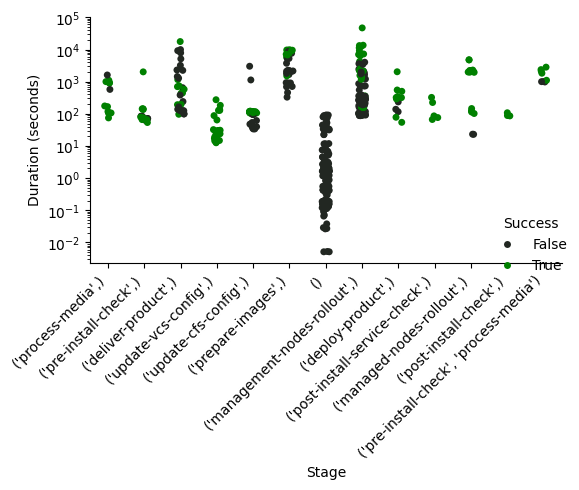

In [13]:
df['Stage'] = df['Stage'].apply(lambda x: str(x))
sns.catplot(data=df, x="Stage", y="Duration (seconds)", hue = 'Success',jitter=True, palette='dark:green')
plt.xticks(rotation=45, ha='right')
plt.yscale("log")
plt.tight_layout()
plt.show()

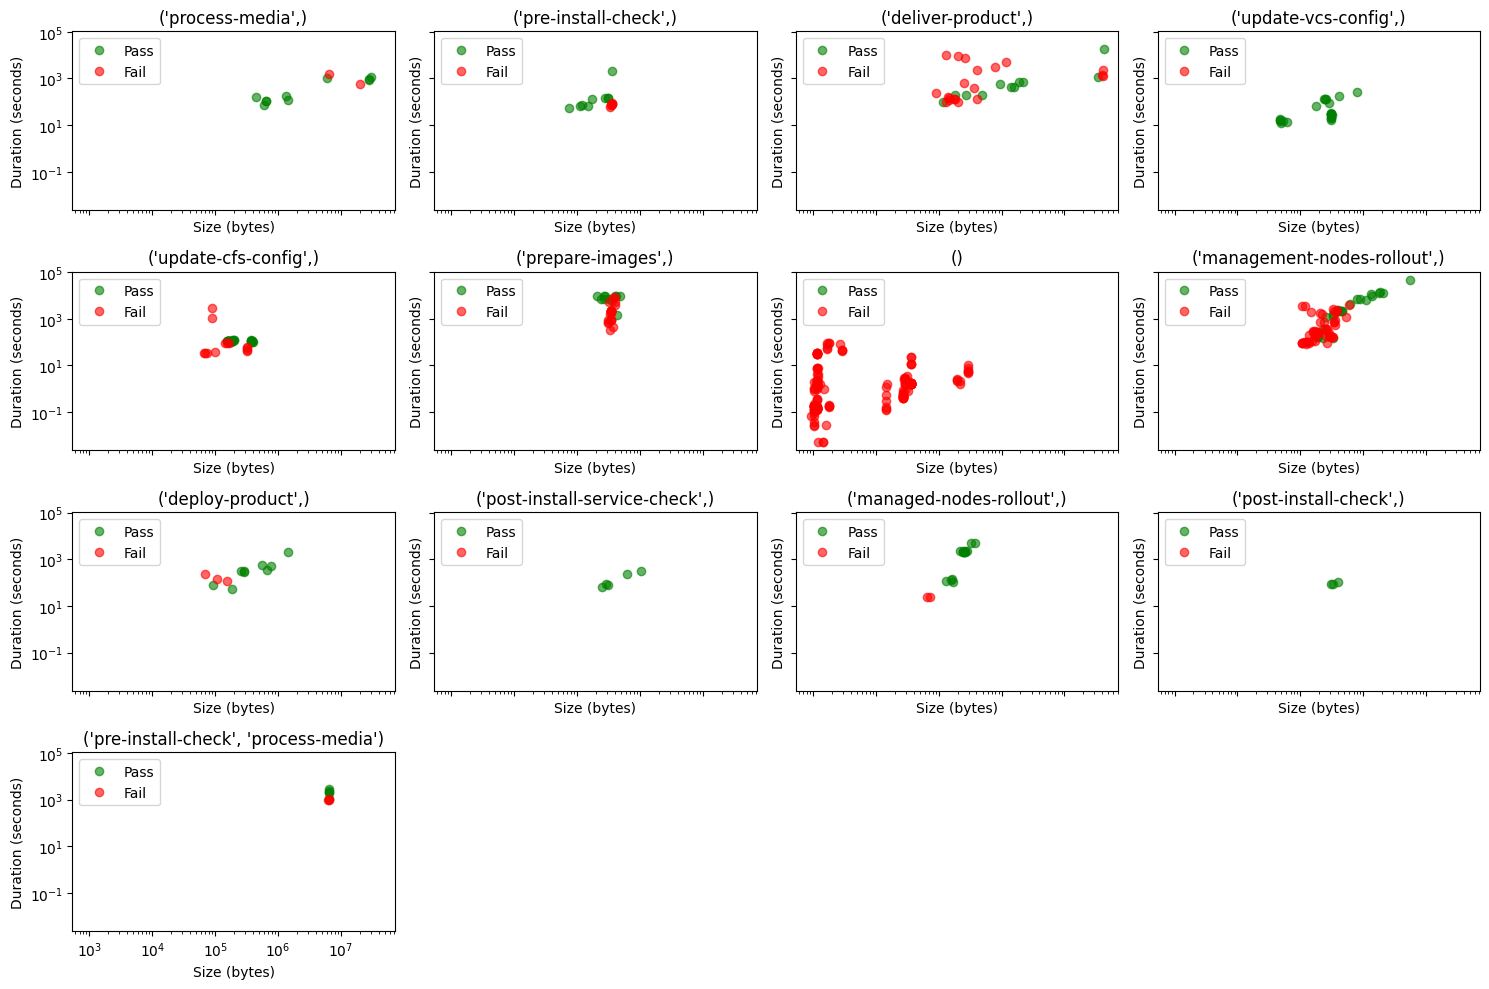

In [15]:
# Explode the stages so that each row represents a single stage
df_exploded = df.explode('Stage')

# Get unique stages
unique_stages = df_exploded['Stage'].unique()

# Determine the number of rows and columns for subplots
n_cols = 4
n_rows = -(-len(unique_stages) // n_cols)  # Ceiling division

# Create figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

# Plot each stage in a separate subplot
for i, stage in enumerate(unique_stages):
    ax = axes[i]
    stage_data = df_exploded[df_exploded['Stage'] == stage]
    
    # Plot points for success and failure
    ax.plot(stage_data[stage_data['Success']]['Size (bytes)'], stage_data[stage_data['Success']]['Duration (seconds)'], "go", alpha=0.6, label="Pass")
    ax.plot(stage_data[~stage_data['Success']]['Size (bytes)'], stage_data[~stage_data['Success']]['Duration (seconds)'], "ro", alpha=0.6, label="Fail")
    
    # Set log scale for x and y axes
    ax.set_xscale("log")
    ax.set_yscale("log")
    
    # Set title and labels
    ax.set_title(stage)
    ax.set_xlabel("Size (bytes)")
    ax.set_ylabel("Duration (seconds)")
    ax.legend(loc='upper left')

# Adjust layout
plt.tight_layout()

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Show plot
plt.show()

Number of Successes and Failures for Each Stage:
Success                                 False  True 
Stage                                               
('deliver-product',)                     20.0   11.0
('deploy-product',)                       3.0    9.0
('managed-nodes-rollout',)                2.0   15.0
('management-nodes-rollout',)            52.0   23.0
('post-install-check',)                   0.0    3.0
('post-install-service-check',)           0.0    5.0
('pre-install-check', 'process-media')    3.0    5.0
('pre-install-check',)                    6.0   10.0
('prepare-images',)                      23.0   11.0
('process-media',)                        2.0   10.0
('update-cfs-config',)                   13.0   28.0
('update-vcs-config',)                    0.0   23.0
()                                      170.0    0.0


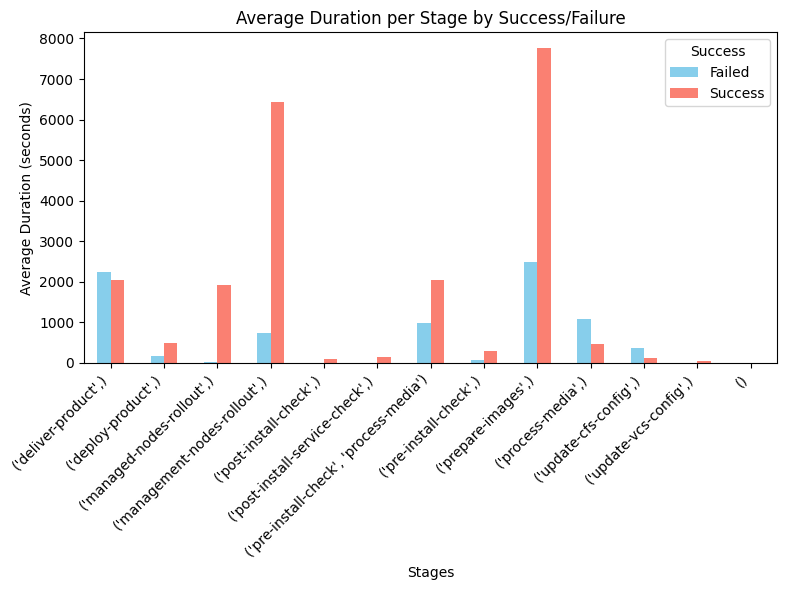

In [16]:
# Group by stages and success, then calculate average duration and counts
grouped_df = df_exploded.groupby(['Stage', 'Success'])['Duration (seconds)'].agg(['mean', 'count']).unstack().fillna(0)
average_duration_df = grouped_df['mean']
counts_df = grouped_df['count']

# Print the number of successes and failures for each stage
print("Number of Successes and Failures for Each Stage:")
print(counts_df)

# Plot the grouped bar chart for average duration
fig, ax = plt.subplots(figsize=(8, 6))
average_duration_df.plot(kind='bar', ax=ax, color=['skyblue', 'salmon'])

# Customize the plot
ax.set_xlabel('Stages')
ax.set_ylabel('Average Duration (seconds)')
ax.set_title('Average Duration per Stage by Success/Failure')
ax.legend(title='Success', labels=['Failed', 'Success'])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

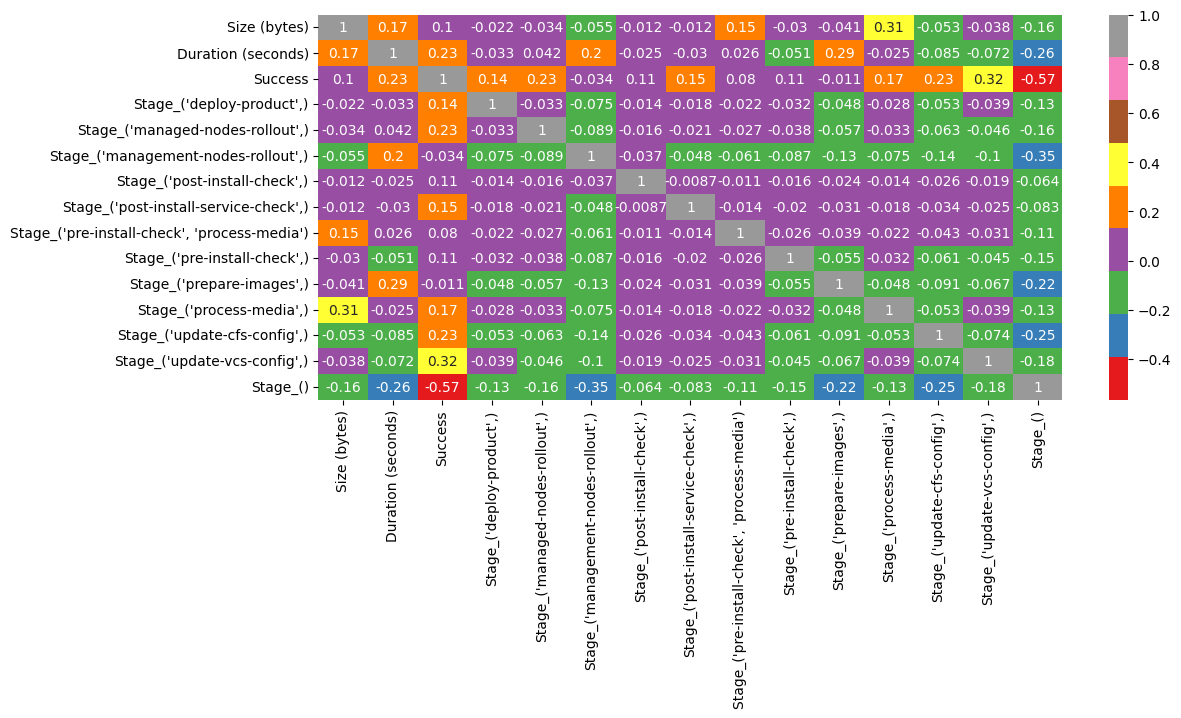

In [17]:
# Compute the correlation matrix
plt.figure(figsize=(12, 5))
df_encoded = pd.get_dummies(df, columns=['Stage'], drop_first=True)

# Select columns of interest for correlation
cols = ['Size (bytes)', 'Duration (seconds)', 'Success'] + list(df_encoded.columns[df_encoded.columns.str.startswith('Stage_')])

# Calculate correlation matrix
correlation_matrix = df_encoded[cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='Set1')
plt.show()

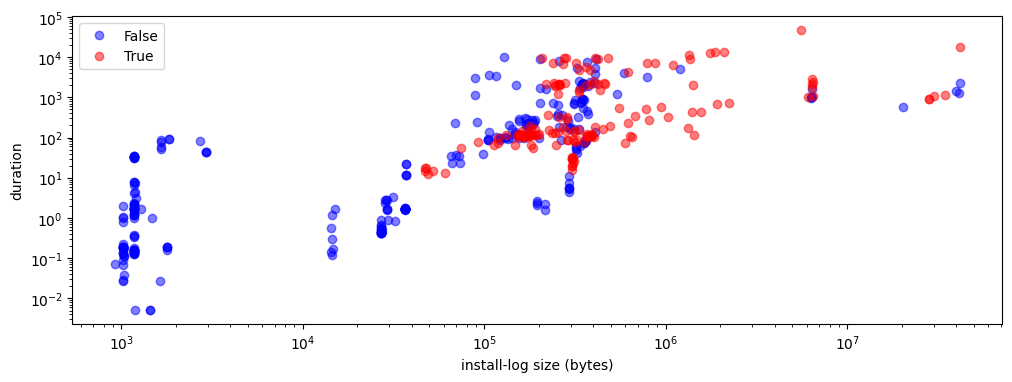

In [18]:
# Generate random colors for clusters
random.seed(1)
colormap = plt.cm.brg
def plot_clusters():
    clusters = df_dummy.cluster.unique()
    plt.figure(figsize=(12,4))
    for i, cluster in enumerate(sorted(clusters)):
        color = colormap(float(i) / len(clusters))
        plt.plot(
            "Size (bytes)",
            "Duration (seconds)",
            "o",
            data=df_dummy[df_dummy.cluster == cluster],
            color=color,
            alpha=0.5,
            label=cluster,
        )
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("install-log size (bytes)")
    plt.ylabel("duration")
    plt.legend()
    plt.show()
df_dummy = df.assign(cluster=df.Success)
plot_clusters()

In [19]:
import os
import re
import pandas as pd

# Function to read the content of the install.log file
def read_install_log(install_log_path):
    """Read the content of the install.log file."""
    if os.path.isfile(install_log_path):
        with open(install_log_path, 'r', encoding='utf-8') as file:
            return file.readlines()
    return []

# Define the directories
main_directory = 'C:/Users/heman/Desktop/HPE/Project Logs HPE'
new_directory = os.path.join(main_directory, 'logs-new')
csv_output_dir = 'C:/Users/heman/Desktop/HPE/Project Logs HPE/log csv files New'
os.makedirs(csv_output_dir, exist_ok=True)

# Regex patterns for parsing log messages
message_pattern = r"^(\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}\.\d+Z)\s+(\w+)\s+\[([\w\s-]+)\]\s+(.*)$"
folder_name_pattern = r"^\d{14}$"  # Pattern for folder names like 20240322064543

def process_logs(directory, is_new_structure=False):
    if is_new_structure:
        for folder in os.listdir(directory):
            subfolder_path = os.path.join(directory, folder, 'log')
            if not os.path.isdir(subfolder_path):
                #print(f"{subfolder_path} is not a directory. Skipping.")
                continue

            for job_folder in os.listdir(subfolder_path):
                if not re.match(folder_name_pattern, job_folder):
                    #print(f"Skipping folder: {job_folder}")
                    continue

                job_path = os.path.join(subfolder_path, job_folder)
                install_log_path = os.path.join(job_path, 'install.log')

                if os.path.isdir(job_path) and os.path.isfile(install_log_path):
                    process_install_log(install_log_path, folder, job_folder)
    else:
        for job_folder in os.listdir(directory):
            if not re.match(folder_name_pattern, job_folder):
                #print(f"Skipping folder: {job_folder}")
                continue

            job_path = os.path.join(directory, job_folder)
            install_log_path = os.path.join(job_path, 'install.log')

            if os.path.isdir(job_path) and os.path.isfile(install_log_path):
                process_install_log(install_log_path, '', job_folder)

def process_install_log(install_log_path, parent_folder, job_folder):
    log_lines = read_install_log(install_log_path)

    if log_lines:
        data = []
        for line in log_lines:
            match = re.match(message_pattern, line)
            if match:
                d = match.group(1)
                l = match.group(2)
                p = match.group(3)
                x = match.group(4)
                data.append({'Timestamp': d, 'Level': l, 'Process': p, 'Message': x})

        dataf = pd.DataFrame(data)
        csv_filename = f'{parent_folder}_{job_folder}.csv' if parent_folder else f'{job_folder}.csv'
        csv_path = os.path.join(csv_output_dir, csv_filename)
        dataf.to_csv(csv_path, index=False)
        #print(f"Processed and saved: {csv_path}")

# Process logs from both the original and new directory structures
process_logs(main_directory, is_new_structure=False)
process_logs(new_directory, is_new_structure=True)


In [20]:
csv_output_dir = 'C:/Users/heman/Desktop/HPE/Project Logs HPE/log csv files New'
log_dir = 'C:/Users/heman/Desktop/HPE/Project Logs HPE/log messages'
clean_dir = 'C:/Users/heman/Desktop/HPE/Project Logs HPE/cleaned logs'


In [21]:
patterns = {
    r'\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}\.\d+Z' : '',
    r'\b\w+-\d+\.\d+\.\d+-\w+\.\d+\.\w+\b': '',
    r'\b(?:[a-zA-Z]:|\\\\[\w\.]+\\[\w.$]+)\\(?:[\w]+\\)*\w([\w.])+': '',
    r'\/[\w\.\-\/]+': ''
}
def convert_log_message(log_message):
    if not isinstance(log_message, str):
        log_message = str(log_message)
    for pattern, placeholder in patterns.items():
        log_message = re.sub(pattern, placeholder, log_message)
    return log_message

In [22]:
# Create the log_dir if it doesn't exist
os.makedirs(log_dir, exist_ok=True)

# Define the function to convert log messages if it's not already defined
def convert_log_message(message):
    # Implement your message conversion logic here
    return message  # Example: return the message as is

for file in os.listdir(csv_output_dir):
    file_path = os.path.join(csv_output_dir, file)
    try:
        data = pd.read_csv(file_path)
        
        if data.empty:
            data = pd.DataFrame({'Timestamp': ['N/A'], 'Level': ['N/A'], 'Process': ['N/A'], 'Message': ['aborted']})
        else:
            data['Message'] = data['Message'].apply(convert_log_message)
            new_file_name = f"{file}.txt"
            new_file_path = os.path.join(log_dir, new_file_name)
            
            # Write the 'Message' column to the new file line by line
            with open(new_file_path, 'w') as f:
                for message in data['Message']:
                    f.write(f"{message}\n")
        
    except pd.errors.EmptyDataError:
        data = pd.DataFrame({'Timestamp': ['N/A'], 'Level': ['N/A'], 'Process': ['N/A'], 'Message': ['aborted']})
        new_file_name = f"{os.path.basename(file)}.txt"
        new_file_path = os.path.join(log_dir, new_file_name)
        with open(new_file_path, 'w') as f:
            f.write("aborted\n")

In [23]:
# Ensure the clean_dir exists
os.makedirs(clean_dir, exist_ok=True)

# Clean and prepare log messages
documents = []
for file in os.listdir(log_dir):
    file_path = os.path.join(log_dir, file)
    cleaned_log = []
    try:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
            lines = f.readlines()
            for line in lines:
                line = line.strip()
                line = re.sub(r'\{.*?\}', '', line)
                if not line.startswith(('+', '[', '/dev', 'tmpfs', 'shm', '#', '{', '--', 'Alloc')):
                    cleaned_log.append(line)
                    
        # Remove the '.csv.txt' extension from the file name
        file_base_name = os.path.splitext(file)[0]
        output_file = os.path.join(clean_dir, f'{file_base_name}_cleaned_log.txt')
        
        with open(output_file, 'w', encoding='utf-8') as f:
            if not cleaned_log:
                f.write('aborted')
            else:
                f.write('\n'.join(cleaned_log))
        documents.append(output_file)
    except UnicodeDecodeError:
        print(f"Could not read file {file_path} due to encoding issues.")

In [25]:
# List all files in the directory
files = os.listdir(csv_output_dir)

# Assuming you want to print rows from the first CSV file found in csv_dir
for file in files:
    if file.endswith('.csv'):
        file_path = os.path.join(csv_output_dir, file)
        dfF = pd.read_csv(file_path)
        
        # Print the first few rows of the DataFrame
        print(f"First few rows of {file}:")
        print(dfF.head())
        
        # Stop after printing the first CSV file found
        break

First few rows of 20240322064543.csv:
                     Timestamp Level  \
0  2024-03-22T06:45:46.938332Z  INFO   
1  2024-03-22T06:45:46.944760Z  INFO   
2  2024-03-22T06:45:48.290155Z   DBG   
3  2024-03-22T06:45:48.290479Z   DBG   
4  2024-03-22T06:45:48.290870Z   DBG   

                                             Process  \
0  extract-release-distributions                 ...   
1  extract-release-distributions                 ...   
2  extract-release-distributions                 ...   
3  extract-release-distributions                 ...   
4  extract-release-distributions                 ...   

                             Message  
0  BEG extract-release-distributions  
1                BEG start-operation  
2         Starting Workflow Executor  
3               Creating a  executor  
4      Using executor retry strategy  


In [26]:
# List all files in the directory
files = os.listdir(clean_dir)

# Assuming you want to print lines from the first text file found in clean_dir
for file in files:
    if file.endswith('.txt'):
        file_path = os.path.join(clean_dir, file)
        
        # Open and read the file line by line
        print(f"First few lines of {file}:")
        with open(file_path, 'r', encoding='utf-8') as f:
            for i, line in enumerate(f):
                if i < 9:  # Print first 5 lines
                    print(line.strip())
                else:
                    break
        
        # Stop after printing the first text file found
        break

First few lines of 20240322064543.csv_cleaned_log.txt:
BEG extract-release-distributions
BEG start-operation
Starting Workflow Executor
Creating a  executor
Using executor retry strategy
Executor initialized
Start loading input artifacts...
Starting Workflow Executor
Creating a  executor


In [27]:
token_pattern = r"\b[a-zA-Z_][a-zA-Z0-9_\-/.:]+\b"

In [28]:
import time
# Function to read install logs
def read_install_log_text(job_path):
    """Read the content of the install.log file."""
    install_log_path = os.path.join(job_path, 'install.log')
    if os.path.isfile(install_log_path):
        with open(install_log_path, 'r') as file:
            return file.read()
    return ""

# Function to preprocess logs
def preprocess_log(log_data):
    preprocessed_lines = []
    for line in log_data.splitlines():
        # Skip lines that don't start with a timestamp
        if not re.match(r'^\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}\.\d{6}Z', line):
            continue
        # Skip lines containing JSON-like objects
        if re.match(r'^\s*[{[].*', line):
            continue
        # Skip lines containing multiple '>' characters
        if re.search(r'>.*>', line):
            continue
        # Skip lines with JSON-like dictionaries within them
        if re.search(r'{.*}', line):
            continue
        # Remove text within square brackets except for lines containing "stages"
        if 'stages' not in line:
            line = re.sub(r'\[.*?\]', '', line)
        # Strip any leading/trailing whitespace that might have been left
        line = line.strip()
        preprocessed_lines.append(line)
    return '\n'.join(preprocessed_lines)

# Create a list to store the content of install logs
install_logs = []

# Populate install_logs list with the content of install logs
for index, row in df.iterrows():
    log_content = read_install_log_text(row['Job Name'])
    processed_log = preprocess_log(log_content)
    install_logs.append(processed_log)

# Calculate TF-IDF matrix
t0 = time.time()
vectorizer = TfidfVectorizer(
    input="content",
    min_df=0.03,
    ngram_range=(1,2),
    token_pattern=token_pattern,
    stop_words='english'
)
tfidf_matrix = vectorizer.fit_transform(install_logs)

print(f"Done in {time.time()-t0:.2f} seconds")
print(f"TF-IDF matrix: {tfidf_matrix.shape[0]} documents x {tfidf_matrix.shape[1]} terms")

Done in 1.99 seconds
TF-IDF matrix: 447 documents x 1239 terms


In [29]:
terms = vectorizer.get_feature_names_out()

print(" | ".join(random.choices(terms, k=100)))

crashkernel log_buf_len | static | s3://boot-images/25d9aea0-1238-47e2-9c18-07fd58a5c3fb/initrd | enabled | loading | ip mgmt1:auto6 | prom-metrics dbg | script output | clusters | associated session | start loading | initrd.img.xz root | s3 info | aborting | ip | rendered | debug dbg | using static | transitioned running | attribute keys | artifact dbg | mgmt1:auto6 | url | image storage-secure-storage-ceph-6.1.72-x86_64.squashfs | dbg test | info workflow | associated session | dbg upgrading | int | loading input | dependencies | deleting | dbg total | kernel | etc/cray/upgrade/csm/csm-upgrade-3/management-bootprep.yaml prepare-images | argo workflow/csm-upgrade-2203-ppg15-deliver-product-6m7c8 | start-operation dbg | ncn dbg | prepare-management-images | dbg generating | workflow/csm-upgrade-2203-ppg15-deliver-product-6m7c8 | stored | container completed | fix | rendered | rd.writable.fsimg | upload csm | info waiting | stage dbg | rd.dm rd.neednet | exit | occurred nonetype | tarba

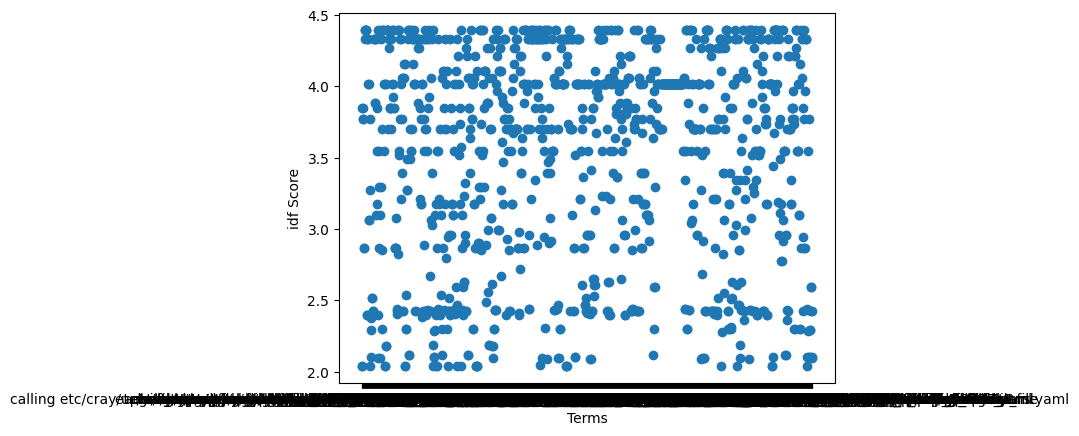

In [30]:
# get idf values
# print("\nidf values:")
x_data= []
y_data = []
for ele1, ele2 in zip(vectorizer.get_feature_names_out(), vectorizer.idf_):
    # print(ele1, ":", ele2)
    x_data.append(ele1)
    y_data.append(ele2)
    
plt.plot(x_data, y_data, 'o')
plt.xlabel("Terms")
plt.ylabel("idf Score")
plt.show()

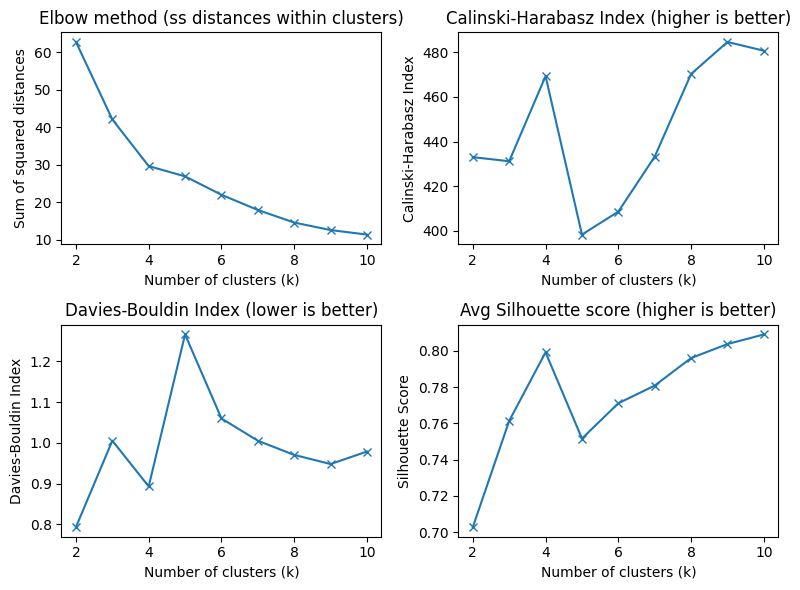

In [31]:
from sklearn.cluster import KMeans
from sklearn import metrics

def kmeans_metrics(x, kmax=11):
    ss = []  # Sum of squared distances of samples to their closest cluster center
    ch = []  # Calinski-Harabasz index
    sc = []  # Silhouette Coefficient
    db = []  # Davies-Bouldin index

    k_range = range(2, kmax)
    x_arr = x.toarray()  # several metrics don't work with sparse arrays
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=123)
        kmeans.fit(x_arr)
        labels = kmeans.labels_
        ss.append(kmeans.inertia_)
        ch.append(metrics.calinski_harabasz_score(x_arr, labels))
        sc.append(metrics.silhouette_score(x_arr, labels))
        db.append(metrics.davies_bouldin_score(x_arr, labels))

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 6))
    fig.subplots_adjust(wspace=2, hspace=2)  # Adjust horizontal and vertical space

    ax1.plot(k_range, ss, "x-")
    ax1.set_title("Elbow method (ss distances within clusters)")
    ax1.set_ylabel("Sum of squared distances")
    ax1.set_xlabel("Number of clusters (k)")

    ax2.plot(k_range, ch, "x-")
    ax2.set_title("Calinski-Harabasz Index (higher is better)")
    ax2.set_ylabel("Calinski-Harabasz Index")
    ax2.set_xlabel("Number of clusters (k)")

    ax3.plot(k_range, db, "x-")
    ax3.set_title("Davies-Bouldin Index (lower is better)")
    ax3.set_ylabel("Davies-Bouldin Index")
    ax3.set_xlabel("Number of clusters (k)")

    ax4.plot(k_range, sc, "x-")
    ax4.set_title("Avg Silhouette score (higher is better)")
    ax4.set_ylabel("Silhouette Score")
    ax4.set_xlabel("Number of clusters (k)")

    plt.tight_layout()
    plt.show()

# Example usage:
kmeans_metrics(tfidf_matrix)


In [32]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=123)
kmeans.fit(tfidf_matrix)
df = df.assign(cluster=kmeans.labels_)

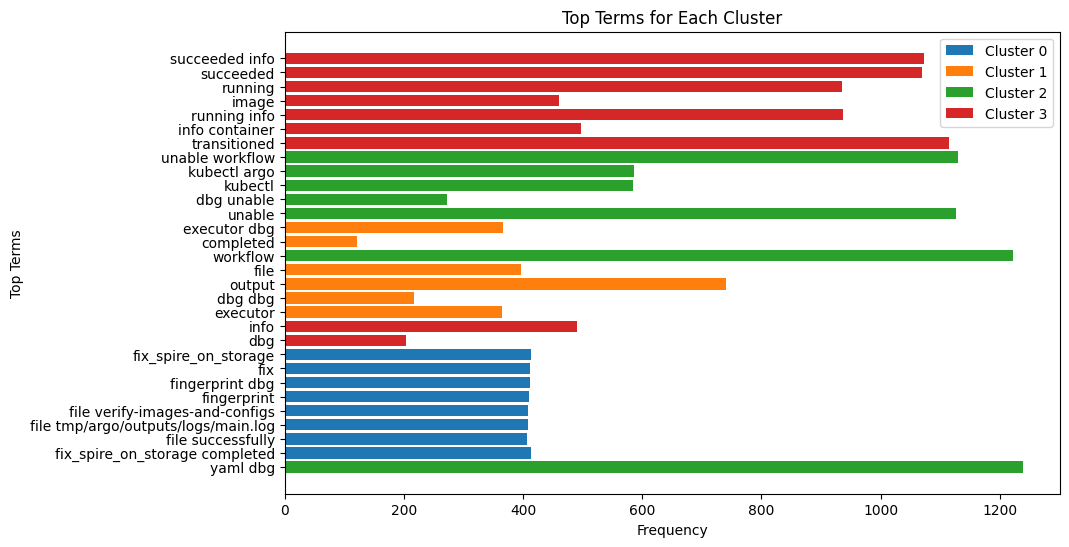

4 clusters with the following metrics:
  - Silhouette coefficient: 0.80
  - Calinski-Harabasz index: 469.28
  - Davies-Bouldin index: 0.89
A list of the most common terms in each cluster:
Cluster 0: yaml dbg fix_spire_on_storage completed file successfully file tmp/argo/outputs/logs/main.log file verify-images-and-configs fingerprint fingerprint dbg fix fix_spire_on_storage
Cluster 1: dbg info executor dbg dbg output file workflow completed executor dbg
Cluster 2: dbg unable dbg unable info workflow kubectl kubectl argo unable workflow yaml dbg
Cluster 3: info dbg transitioned info container running info image running succeeded succeeded info


In [33]:
def cluster_terms(topn=10):
    """Print the top tokens for each cluster"""
    terms = vectorizer.get_feature_names_out()
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    for i in range(k):
        print("Cluster %d:" % i, end="")
        for ind in order_centroids[i, :topn]:
            print(" %s" % terms[ind], end="")
        print()

def cluster_terms_plot(topn=10):
    """Plot the top tokens for each cluster"""
    terms = vectorizer.get_feature_names_out()
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    fig, ax = plt.subplots(figsize=(10, 6))
    for i in range(k):
        terms_freq = [terms[ind] for ind in order_centroids[i, :topn]]
        freq_values = [order_centroids[i, j] for j in range(topn)]
        ax.barh(terms_freq, freq_values, label=f'Cluster {i}')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Top Terms')
    ax.set_title('Top Terms for Each Cluster')
    ax.legend()
    plt.show()

cluster_terms_plot(9)


def describe_clusters():
    x = tfidf_matrix.toarray()
    print(k, "clusters with the following metrics:")
    print(
        f"  - Silhouette coefficient: {metrics.silhouette_score(tfidf_matrix, kmeans.labels_):.2f}"
    )
    print(
        f"  - Calinski-Harabasz index: {metrics.calinski_harabasz_score(x, kmeans.labels_):.2f}"
    )
    print(
        f"  - Davies-Bouldin index: {metrics.davies_bouldin_score(x, kmeans.labels_):.2f}"
    )
    print("A list of the most common terms in each cluster:")
    cluster_terms(9)


describe_clusters()

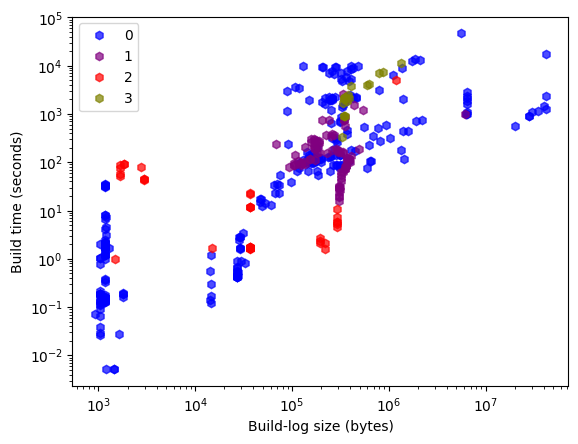

In [34]:
import matplotlib.pyplot as plt

def plot_clusters(df):
    # Get unique clusters
    clusters = df['cluster'].unique()
    for i, cluster in enumerate(sorted(clusters)):
        color = colormap(float(i) / len(clusters))
        cluster_df = df[df['cluster'] == cluster]
        if cluster_df.empty:
            continue
        plt.plot(
            cluster_df["Size (bytes)"],
            cluster_df["Duration (seconds)"],
            "h",
            color=color,
            alpha=0.7,
            label=cluster,
        )
    if df["Size (bytes)"].min() > 0:
        plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Build-log size (bytes)")
    plt.ylabel("Build time (seconds)")
    plt.legend()
    plt.show()

# Example usage:
plot_clusters(df)


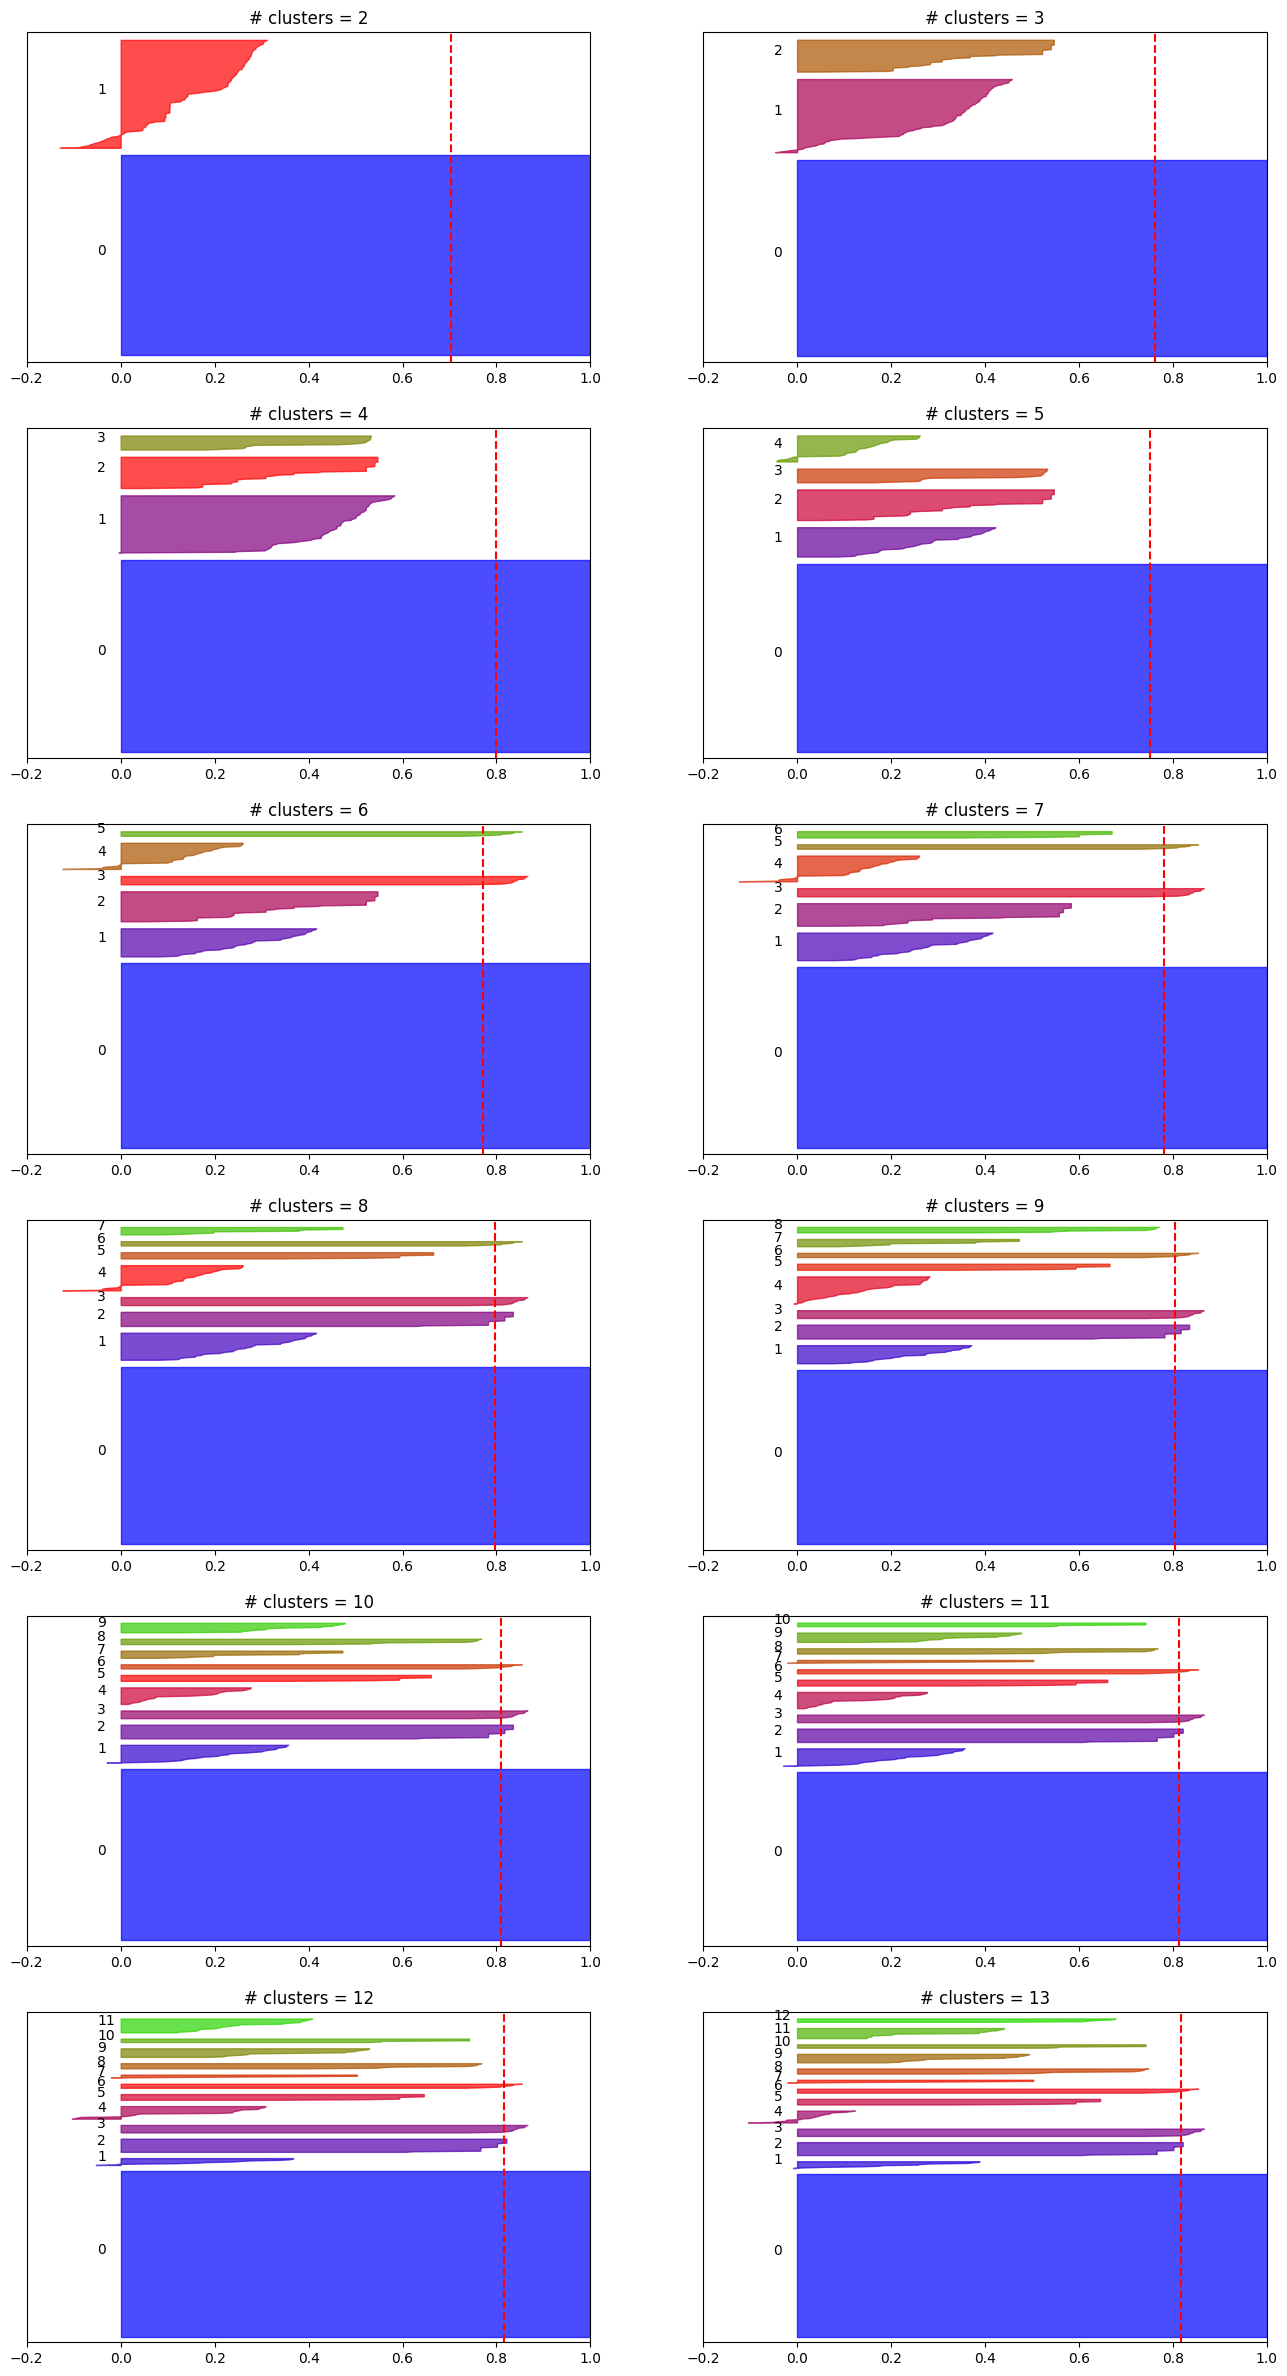

In [35]:
def kmeans_silhouette(tfidf_matrix, kmax=13):
    cols = 2
    rows = int((kmax - 1) / cols)
    fig, axs = plt.subplots(rows, cols)
    ax = axs.flatten()
    fig.set_size_inches(cols * 8, rows * 5)
    for n, k in enumerate(range(2, kmax + 1)):
        # The silhouette coefficient can range from -1, 1 but all of our tests
        # lie within [-0.2, 1]
        ax[n].set_xlim([-0.2, 1])
        # The (k+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax[n].set_ylim([0, tfidf_matrix.shape[0] + (k + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 123 for reproducibility.
        clusterer = KMeans(n_clusters=k, random_state=123)
        cluster_labels = clusterer.fit_predict(tfidf_matrix)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = metrics.silhouette_score(tfidf_matrix, cluster_labels)
        # print(f"For {k} clusters the average silhouette_score is {silhouette_avg:.2f}")

        # Compute the silhouette scores for each sample
        sample_silhouette_values = metrics.silhouette_samples(tfidf_matrix, cluster_labels)

        y_lower = 10
        for i in range(k):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[
                cluster_labels == i
            ]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = colormap(float(i) / k)
            ax[n].fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax[n].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        # The vertical line for average silhouette score of all the values
        ax[n].axvline(x=silhouette_avg, color="red", linestyle="--")

        ax[n].set_title(f"# clusters = {k}")
        ax[n].set_yticks([])  # Clear the yaxis labels / ticks
        ax[n].set_xticks(np.arange(-0.2, 1.1, 0.2))

# Example usage:
kmeans_silhouette(tfidf_matrix)
plt.show()